In [32]:
#imports
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

import scipy as sp
import scipy.linalg as spl
import scipy.stats as sps

import matplotlib.pyplot as plt

In [41]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from our_package import * #allows us to use our functions directly

In [4]:
#we call the different functions
T = 5
Lambda = 1

D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T, a, b)
Y = Computation_Y(T, Lambda)
x,x_tilde = ComputeArgmax(T,Lambda, Y)
mu,mu_tilde = ComputeMeans(T,Lambda, Y)
q1 = ComputeQuantiles(T,Lambda,0.975*np.ones(T), Y)
q2 = ComputeQuantiles(T,Lambda,0.025*np.ones(T), Y)
med = ComputeQuantiles(T,Lambda,0.5*np.ones(T), Y)
sim_theta,sim_theta_tilde,sim_accepts,sim_gammas = MetropolisHastings(T,Lambda, Y)
Mean=np.sum(sim_theta,axis=0)/sim_theta.shape[0]
q = np.array([2.5,50,97.5])
quantiles_emp = Quantiles(sim_theta_tilde, q,T)

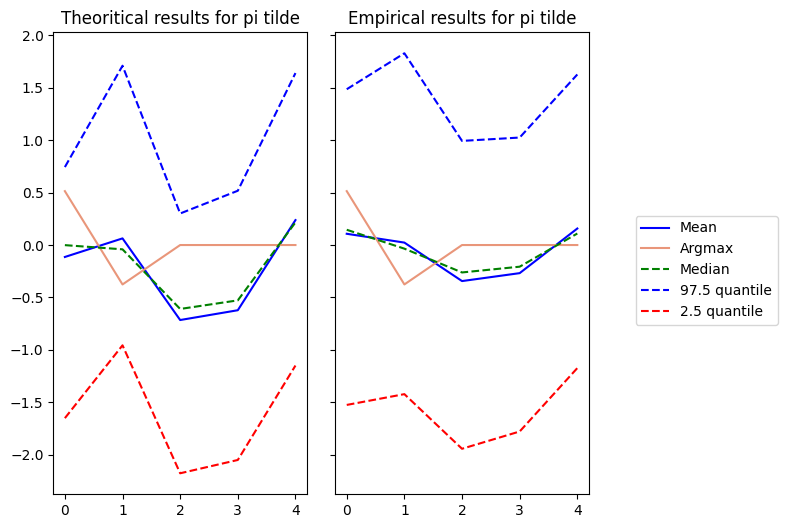

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), sharey=True)
#Plot of theoritical results
axes[0].plot(mu_tilde,color="blue",label="Mean")
axes[0].plot(x_tilde,color="darksalmon",label="Argmax")
axes[0].plot(med,'g--',label="Median")
axes[0].plot(q1,'b--',label="97.5 quantile")
axes[0].plot(q2,'r--',label="2.5 quantile")
axes[0].set_title("Theoritical results for pi tilde")


#Plot of empirical results
axes[1].plot(D@Mean,color="blue")
axes[1].plot(x_tilde,color="darksalmon")
axes[1].plot(quantiles_emp[1],'g--')
axes[1].plot(quantiles_emp[2],'b--')
axes[1].plot(quantiles_emp[0],'r--')
axes[1].set_title("Empirical results for pi tilde")

# Shrink current axis by 20%
box0,box1 = axes[0].get_position(),axes[1].get_position()
axes[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
axes[1].set_position([box1.x0*0.8, box1.y0, box1.width * 0.8, box1.height])
fig.legend(loc=(0.8*box1.x0+box1.width,box1.height/2))
plt.show()

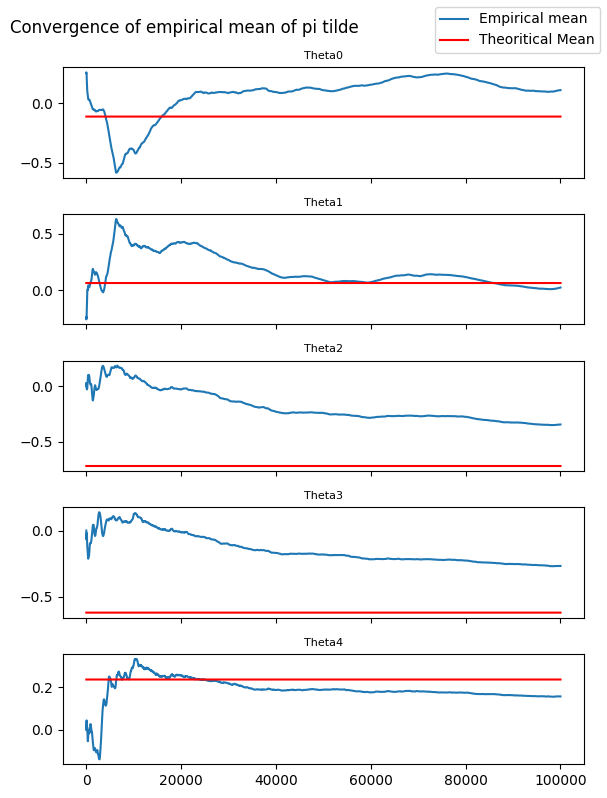

In [13]:
#Convergence plot of the mean of theta_tilde
nb_iter=sim_theta.shape[0]
x=np.linspace(1,nb_iter,nb_iter)
mean_tab=np.cumsum(sim_theta_tilde,axis=0)

fig,Axes = plt.subplots(T,1,figsize=(6,8),sharex=True)
for i in range(T):
    ax = Axes[i]
    res=mean_tab[:,i]/x
    ax.plot(x,res,label="Empirical mean" if i==0 else "")
    ax.plot(x,mu_tilde[i]*np.ones(nb_iter),'r',label="Theoritical Mean" if i==0 else "")
    ax.set_title(f"Theta{i}",fontsize=8)

fig.suptitle("Convergence of empirical mean of pi tilde", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

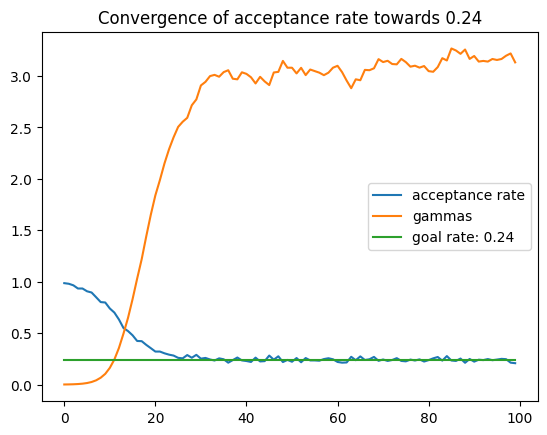

In [18]:
plt.plot(sim_accepts,label="acceptance rate")
plt.plot(sim_gammas[:-1],label="gammas")
plt.plot(np.ones(len(sim_accepts))*0.24,label="goal rate: 0.24")
plt.title("Convergence of acceptance rate towards 0.24")
plt.legend()
plt.show()

In [84]:
Lambdas = [0.1,0.5,0.8,1,1.3,1.6,2,4,7,9]
T = 3
niter = 1e5
n = len(Lambdas)
approx = np.zeros((min(int(niter),int(1e3)),T,n))
for k in reversed(range(n)):
    L = Lambdas[k]
    if k==(n-1) :
        sim_theta_tilde,x = MetropolisHastingsFast(T, L, Y, niter=niter)
    else:
        sim_theta_tilde, *_ = MetropolisHastingsFast(T, L, Y, niter=niter)
    res = np.cumsum(sim_theta_tilde, axis=0)
    res /= x[:,np.newaxis]
    approx[:,:,k] = res
    print(f"finished {k} iteration")

finished 9 iteration
finished 8 iteration
finished 7 iteration
finished 6 iteration
finished 5 iteration
finished 4 iteration
finished 3 iteration
finished 2 iteration
finished 1 iteration
finished 0 iteration


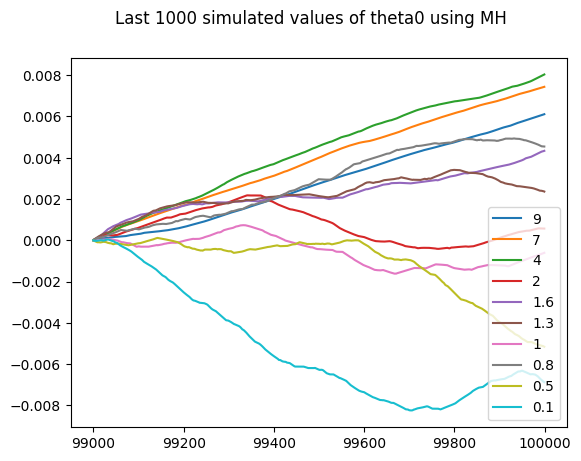

In [88]:
fig = plt.figure()
for k in reversed(range(n)):
    plt.plot(x,approx[:,0,k],label=f"{Lambdas[k]}")
plt.legend()
plt.suptitle("Last 1000 simulated values of theta0 using MH") 
plt.show()

In [86]:
errors = np.zeros(np.shape(approx))
for k in reversed(range(n)):
    _,mu_tilde = ComputeMeans(T,Lambdas[k],Y) # size T
    errors[:,:,k] = approx[:,:,k] - np.ones((1000,1))@mu_tilde[np.newaxis,:]

(1000, 10) (1000, 10)


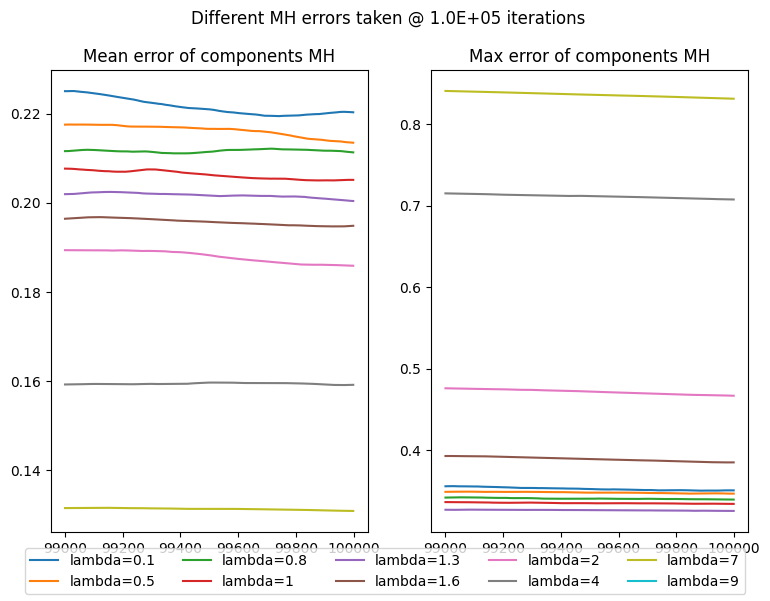

In [87]:
max_error = np.max(errors,axis=1)
mean_error = np.mean(errors,axis=1)
print(np.shape(mean_error),np.shape(max_error))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,6))
fig.suptitle(f"Different MH errors taken @ {niter:.1E} iterations")
ax1.set_title("Mean error of components MH")
ax2.set_title("Max error of components MH")
for k in range(n):
    ax1.plot(x,mean_error[:,k])
    ax2.plot(x,max_error[:,k], label=f"lambda={Lambdas[k]}")
fig.legend(ncols=n//2,loc="lower center")
plt.show()